For given graph of tasks with its execution costs we calculate minimum duration for given budget.

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphcosts.txt"

First we read graph from *graphName* file.

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

Then we get graphic representation of graph.

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

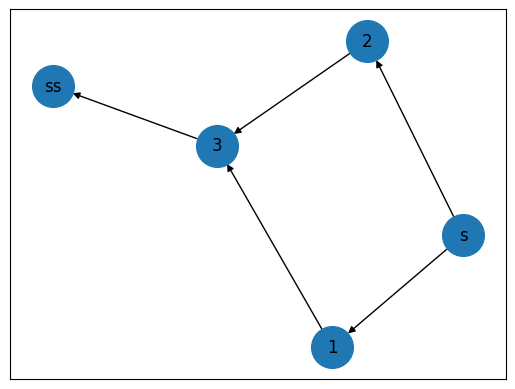

In [5]:
drawGraph(GxNodes, GxEdges)

Then we get costs for durations for each tasks

In [6]:
def getCost(filename):
    # one node represents one task, each task has array of durations with assigned costs
    # here we read thoes (duration, value) pairs and add them in dict for each node
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [7]:
costs = getCost(costsName)
costs

defaultdict(list,
            {'1': [(2, 20), (5, 8)],
             '2': [(3, 8)],
             '3': [(1, 20), (2, 10), (4, 5)],
             's': [(0, 0)],
             'ss': [(0, 0)]})

Duration is calculated by earliest start time. Next group of tasks in order can start earliest when last task in previous group is finnished.

In [8]:
def getEarliestStartTime(nodes, solution, graph, costs, earliestStartTime):
    if nodes == []:
        return earliestStartTime
    durations = set()
    newNodes = []
#     print(nodes)
    for node in nodes:
#         print(node)
        if node == 'ss':
            durations.add(0)
            continue
        step = solution[int(node)]
        durations.add(costs[node][step][0])
        for ancestor in graph[node]:
            newNodes.append(ancestor)
    earliestStartTime += max(durations)
    return getEarliestStartTime(newNodes, solution, graph, costs, earliestStartTime)

Budget value is calculated trivially by summing costs for given execution time and given task. 

In [9]:
def budgetValue(costs, solution):
    cost = 0
    for index in range(1, len(solution)-1):
        cost += costs[str(index)][solution[index]][1]
    return cost

Brute force algorithm used to get all combinations of costs and budgets.

In [10]:
import queue

def bruteForce(graph, costs, budget):
    # queue in which we will put all the combinations of durations of tasks for project
    q = queue.Queue()
    # number of nodes except source and super sink nodes which are dummy nodes
    numOfNodes = len(graph) - 2
    
    executionPlan = [0 for i in range(len(graph))]
    
    for i in range(1, numOfNodes+1):
        old = executionPlan[i]
        for step in range(len(costs[str(i)])):
            executionPlan[i] = step
            q.put(executionPlan.copy())
            for j in reversed(range(1, i)):
                oldInner = executionPlan[j]
                for step in range(len(costs[str(j)])):
                    executionPlan[j] = step
                    q.put(executionPlan.copy())
                executionPlan[j] = oldInner
        executionPlan[i] = old

    num = 0
    solutionsSet = defaultdict(list)
    while not q.empty():
        solution = q.get()
        duration = getEarliestStartTime(graph['s'], solution, graph, costs, 0)
        solutionBudget = budgetValue(costs, solution)
        
        solutionsSet[(duration, solutionBudget)] = solution.copy()
    return solutionsSet

We used output of brute force algorithm to draw graph of all (time, cost) combinations and Pareto-optimal set. This is also used to check accuracy of our algorithm, since there is solution for this set of tasks in literature.

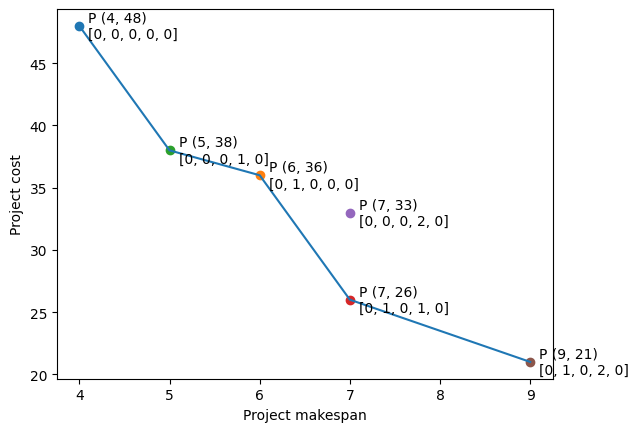

In [11]:
solutionsSet = bruteForce(nodes, costs, 100)

for s in solutionsSet:
    plt.scatter(s[0], s[1])
    
plt.xlabel("Project makespan")
plt.ylabel("Project cost")

for s in solutionsSet:
    text = "P " + "(" + str(s[0]) + ", " + str(s[1]) + ")" + "\n" + str(solutionsSet[s])
    plt.annotate(text, (s[0] + 0.1 , s[1] - 1))
    
    
    
resultSet = solutionsSet.copy()
for s in solutionsSet.keys():
    for q in solutionsSet.keys():
        if s[0] >= q[0] and s[1] > q[1]:
            resultSet.pop(s)

resultSet = sorted(resultSet, key = lambda x: x[0])
durations = []
budgets = []
for r in resultSet:
    durations.append(r[0])
    budgets.append(r[1])

plt.plot(durations, budgets)
    
plt.show()